# NLP Assignment 2: Language Model - Stranger Things

**Student Name**: HTUT KO KO
**ID**: st126010

This notebook trains an LSTM Language Model on **Stranger Things** TV series dialogue (Seasons 1-4).
Dataset source: [filmicaesthetic/stringr-things](https://github.com/filmicaesthetic/stringr-things)


In [1]:
# --- SETUP & CONFIGURATION ---
import os
import torch
import sys

# Environment Detection
try:
    from google.colab import drive
    IS_COLAB = True
except ImportError:
    IS_COLAB = False

if IS_COLAB:
    print("Detected Google Colab.")
    drive.mount('/content/drive')
    PROJECT_PATH = '/content/drive/MyDrive/NLP/project_A2'
    if not os.path.exists(PROJECT_PATH):
        os.makedirs(PROJECT_PATH, exist_ok=True)
    os.chdir(PROJECT_PATH)
    print(f"Working Directory set to: {os.getcwd()}")
    print("Installing dependencies...")
    %pip install datasets tqdm matplotlib pandas
else:
    print("Detected Local Environment.")
    PROJECT_PATH = '.' if os.path.exists('stranger_things_data.csv') else 'project_A2'
    print(f"Project Path: {PROJECT_PATH}")

# Model Settings
EMB_DIM = 1024
HID_DIM = 1024
BATCH_SIZE = 64
SEQ_LEN = 50

print(f"Config: Emb={EMB_DIM}, Hid={HID_DIM}, Batch={BATCH_SIZE}, Seq={SEQ_LEN}")

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Detected Google Colab.
Mounted at /content/drive
Working Directory set to: /content/drive/MyDrive/NLP/project_A2
Installing dependencies...
Config: Emb=1024, Hid=1024, Batch=64, Seq=50
Using device: cuda


In [2]:
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import datasets
import math
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Task 1. Dataset Acquisition

Loading **Stranger Things** dialogue from CSV.


In [3]:
# Load CSV
csv_path = os.path.join(PROJECT_PATH, 'stranger_things_data.csv') if PROJECT_PATH != '.' else 'stranger_things_data.csv'

if not os.path.exists(csv_path):
    import requests
    print("Downloading Stranger Things dataset...")
    url = "https://raw.githubusercontent.com/filmicaesthetic/stringr-things/main/data/stranger_things_all_dialogue.csv"
    response = requests.get(url)
    with open(csv_path, 'w', encoding='utf-8') as f:
        f.write(response.text)
    print("Download complete.")

df = pd.read_csv(csv_path)
print(f"Loaded {len(df)} rows")
print(df.head())

Loaded 32519 rows
   season  episode  line               raw_text        stage_direction  \
0       1        1     1    [crickets chirping]    [crickets chirping]   
1       1        1     2        [alarm blaring]        [alarm blaring]   
2       1        1     3              [panting]              [panting]   
3       1        1     4  [elevator descending]  [elevator descending]   
4       1        1     5       [elevator dings]       [elevator dings]   

  dialogue start_time  end_time  
0      NaN   00:00:07  00:00:09  
1      NaN   00:00:49  00:00:51  
2      NaN   00:00:52  00:00:54  
3      NaN   00:01:01  00:01:02  
4      NaN   00:01:09  00:01:10  


In [4]:
# Extract dialogue column, filter empty/NaN
dialogues = df['dialogue'].dropna().tolist()
dialogues = [str(d).strip() for d in dialogues if str(d).strip() and str(d).strip() != ' ']
print(f"Total dialogue lines: {len(dialogues)}")

# Combine into single text
raw_text = ' '.join(dialogues)
print(f"Total characters: {len(raw_text)}")

Total dialogue lines: 26041
Total characters: 767904


## Task 2. Model Training

### Preprocessing

In [5]:
def basic_english_tokenizer(text):
    """Simple tokenizer: Lowercase, space punctuation, split."""
    text = text.lower()
    text = re.sub(r'([.,!?()])', r' \1 ', text)
    text = re.sub(r'[^a-z0-9\s.,!?()]', '', text)
    return text.split()

# Save cleaned text for dataset loading
cleaned_path = os.path.join(PROJECT_PATH, 'Stranger_Things_Cleaned.txt') if PROJECT_PATH != '.' else 'Stranger_Things_Cleaned.txt'
with open(cleaned_path, 'w', encoding='utf-8') as f:
    f.write(raw_text)

dataset = datasets.load_dataset('text', data_files={'train': cleaned_path})
print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1
    })
})


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Vocabulary Size: 3043


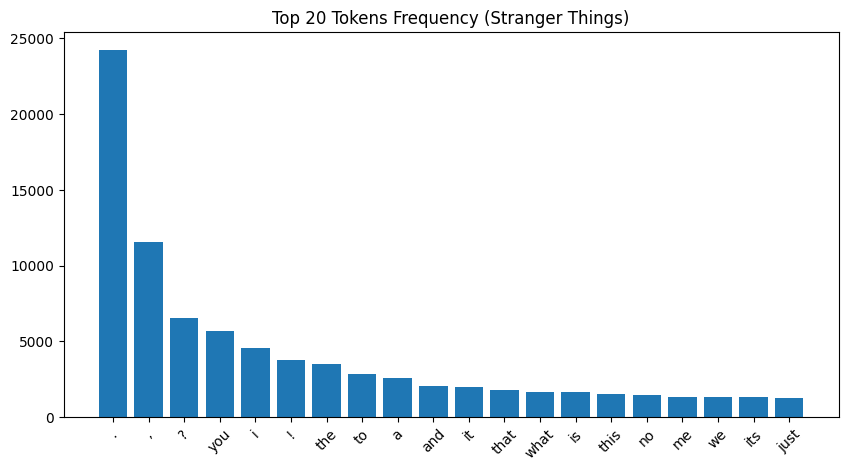

Saved stranger_things_vocab.pt to /content/drive/MyDrive/NLP/project_A2/app/stranger_things_vocab.pt


In [6]:
class SimpleVocab:
    def __init__(self, token_counts, min_freq=1, specials=['<unk>', '<pad>', '<eos>']):
        self.stoi = {}
        self.itos = []
        self.specials = specials
        for s in specials:
            self.stoi[s] = len(self.itos)
            self.itos.append(s)
        sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
        for token, count in sorted_tokens:
            if count >= min_freq:
                if token not in self.stoi:
                    self.stoi[token] = len(self.itos)
                    self.itos.append(token)
        self.unk_index = self.stoi.get('<unk>', 0)
        self.pad_index = self.stoi.get('<pad>', 1)
        self.eos_index = self.stoi.get('<eos>', 2)
    def __len__(self): return len(self.itos)
    def __getitem__(self, token): return self.stoi.get(token, self.unk_index)

# Tokenize
tokenize_data = lambda example: {'tokens': basic_english_tokenizer(example['text'])}
tokenized_dataset = dataset.map(tokenize_data, remove_columns=['text'])

# Build Vocab
token_counts = Counter()
for tokens in tokenized_dataset['train']['tokens']:
    token_counts.update(tokens)

vocab = SimpleVocab(token_counts, min_freq=3)
print(f"Vocabulary Size: {len(vocab)}")

# Visualize
most_common = token_counts.most_common(20)
tokens, counts = zip(*most_common)
plt.figure(figsize=(10, 5))
plt.bar(tokens, counts)
plt.title('Top 20 Tokens Frequency (Stranger Things)')
plt.xticks(rotation=45)
plt.show()

# Save Vocab
def save_artifact(obj, filename):
    app_dir = os.path.join(PROJECT_PATH, 'app')
    if not os.path.exists(app_dir):
        if os.path.exists('app'):
             app_dir = 'app'
        else:
             os.makedirs(app_dir, exist_ok=True)
    path = os.path.join(app_dir, filename)
    torch.save(obj, path)
    print(f"Saved {filename} to {path}")

save_artifact(vocab, 'stranger_things_vocab.pt')

In [7]:
def get_data(dataset, vocab, batch_size):
    data = []
    unk_index = vocab.unk_index
    for example in dataset:
        if example['tokens']:
            tokens = example['tokens'] + ['<eos>']
            tokens = [vocab.stoi.get(token, unk_index) for token in tokens]
            data.extend(tokens)
    data = torch.LongTensor(data)
    num_batches = data.shape[0] // batch_size
    data = data[:num_batches * batch_size]
    data = data.view(batch_size, num_batches)
    return data

train_data = get_data(tokenized_dataset['train'], vocab, BATCH_SIZE)
valid_idx = int(train_data.shape[1] * 0.9)
valid_data = train_data[:, valid_idx:]
train_data = train_data[:, :valid_idx]
print(f"Train Shape: {train_data.shape}")

Train Shape: torch.Size([64, 2671])


### Model Architecture

In [8]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, num_layers, dropout_rate):
        super().__init__()
        self.num_layers = num_layers
        self.hid_dim = hid_dim
        self.emb_dim = emb_dim

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers=num_layers, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hid_dim, vocab_size)
        self.init_weights()

    def init_weights(self):
        init_range = 0.1
        self.embedding.weight.data.uniform_(-init_range, init_range)
        self.fc.weight.data.uniform_(-init_range, init_range)
        self.fc.bias.data.zero_()

    def init_hidden(self, batch_size, device):
        return (torch.zeros(self.num_layers, batch_size, self.hid_dim).to(device),
                torch.zeros(self.num_layers, batch_size, self.hid_dim).to(device))

    def detach_hidden(self, hidden):
        return (hidden[0].detach(), hidden[1].detach())

    def forward(self, src, hidden):
        embedded = self.dropout(self.embedding(src))
        output, hidden = self.lstm(embedded, hidden)
        output = self.dropout(output)
        prediction = self.fc(output)
        return prediction, hidden

vocab_size = len(vocab)
num_layers = 2
dropout_rate = 0.6 if EMB_DIM > 512 else 0.5
lr = 1e-3

model = LSTMLanguageModel(vocab_size, EMB_DIM, HID_DIM, num_layers, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

Trainable parameters: 23,028,707


### Training

Epoch: 1 | Train PPL: 607.987 | Valid PPL: 178.313
Saved stranger_things_model.pt to /content/drive/MyDrive/NLP/project_A2/app/stranger_things_model.pt


Epoch: 2 | Train PPL: 160.810 | Valid PPL: 126.109
Saved stranger_things_model.pt to /content/drive/MyDrive/NLP/project_A2/app/stranger_things_model.pt


Epoch: 3 | Train PPL: 115.566 | Valid PPL: 97.446
Saved stranger_things_model.pt to /content/drive/MyDrive/NLP/project_A2/app/stranger_things_model.pt


Epoch: 4 | Train PPL: 91.368 | Valid PPL: 83.319
Saved stranger_things_model.pt to /content/drive/MyDrive/NLP/project_A2/app/stranger_things_model.pt


Epoch: 5 | Train PPL: 79.009 | Valid PPL: 75.722
Saved stranger_things_model.pt to /content/drive/MyDrive/NLP/project_A2/app/stranger_things_model.pt


Epoch: 6 | Train PPL: 70.390 | Valid PPL: 70.978
Saved stranger_things_model.pt to /content/drive/MyDrive/NLP/project_A2/app/stranger_things_model.pt


Epoch: 7 | Train PPL: 63.761 | Valid PPL: 67.659
Saved stranger_things_model.pt to /content/drive/MyDrive/NLP/project_A2/app/stranger_things_model.pt


Epoch: 8 | Train PPL: 58.356 | Valid PPL: 65.133
Saved stranger_things_model.pt to /content/drive/MyDrive/NLP/project_A2/app/stranger_things_model.pt


Epoch: 9 | Train PPL: 53.980 | Valid PPL: 63.456
Saved stranger_things_model.pt to /content/drive/MyDrive/NLP/project_A2/app/stranger_things_model.pt


Epoch: 10 | Train PPL: 49.707 | Valid PPL: 61.982
Saved stranger_things_model.pt to /content/drive/MyDrive/NLP/project_A2/app/stranger_things_model.pt


Epoch: 11 | Train PPL: 45.992 | Valid PPL: 61.428
Saved stranger_things_model.pt to /content/drive/MyDrive/NLP/project_A2/app/stranger_things_model.pt


Epoch: 12 | Train PPL: 42.697 | Valid PPL: 60.958
Saved stranger_things_model.pt to /content/drive/MyDrive/NLP/project_A2/app/stranger_things_model.pt


Epoch: 13 | Train PPL: 39.615 | Valid PPL: 60.768
Saved stranger_things_model.pt to /content/drive/MyDrive/NLP/project_A2/app/stranger_things_model.pt


Epoch: 14 | Train PPL: 37.022 | Valid PPL: 60.658
Saved stranger_things_model.pt to /content/drive/MyDrive/NLP/project_A2/app/stranger_things_model.pt


Epoch: 15 | Train PPL: 34.359 | Valid PPL: 61.366


Epoch: 16 | Train PPL: 31.263 | Valid PPL: 61.021


Epoch: 17 | Train PPL: 28.877 | Valid PPL: 62.170


Epoch: 18 | Train PPL: 27.710 | Valid PPL: 61.990


Epoch: 19 | Train PPL: 27.046 | Valid PPL: 62.226


Epoch: 20 | Train PPL: 26.807 | Valid PPL: 62.200


Epoch: 21 | Train PPL: 26.630 | Valid PPL: 62.239


Epoch: 22 | Train PPL: 26.557 | Valid PPL: 62.248


Epoch: 23 | Train PPL: 26.538 | Valid PPL: 62.266


Epoch: 24 | Train PPL: 26.500 | Valid PPL: 62.273


Epoch: 25 | Train PPL: 26.455 | Valid PPL: 62.279


Epoch: 26 | Train PPL: 26.402 | Valid PPL: 62.283


Epoch: 27 | Train PPL: 26.477 | Valid PPL: 62.283


Epoch: 28 | Train PPL: 26.392 | Valid PPL: 62.284


Epoch: 29 | Train PPL: 26.439 | Valid PPL: 62.285


Epoch: 30 | Train PPL: 26.447 | Valid PPL: 62.285


Epoch: 31 | Train PPL: 26.419 | Valid PPL: 62.285


Epoch: 32 | Train PPL: 26.455 | Valid PPL: 62.285


Epoch: 33 | Train PPL: 26.460 | Valid PPL: 62.285


Epoch: 34 | Train PPL: 26.393 | Valid PPL: 62.285


Epoch: 35 | Train PPL: 26.462 | Valid PPL: 62.285


Epoch: 36 | Train PPL: 26.550 | Valid PPL: 62.285


Epoch: 37 | Train PPL: 26.493 | Valid PPL: 62.286


Epoch: 38 | Train PPL: 26.400 | Valid PPL: 62.286


Epoch: 39 | Train PPL: 26.438 | Valid PPL: 62.286


Epoch: 40 | Train PPL: 26.462 | Valid PPL: 62.286


Epoch: 41 | Train PPL: 26.432 | Valid PPL: 62.286


Epoch: 42 | Train PPL: 26.443 | Valid PPL: 62.286


Epoch: 43 | Train PPL: 26.498 | Valid PPL: 62.286


Epoch: 44 | Train PPL: 26.461 | Valid PPL: 62.286


Epoch: 45 | Train PPL: 26.468 | Valid PPL: 62.286


Epoch: 46 | Train PPL: 26.471 | Valid PPL: 62.286


Epoch: 47 | Train PPL: 26.566 | Valid PPL: 62.286


Epoch: 48 | Train PPL: 26.426 | Valid PPL: 62.286


Epoch: 49 | Train PPL: 26.501 | Valid PPL: 62.286


Epoch: 50 | Train PPL: 26.441 | Valid PPL: 62.286


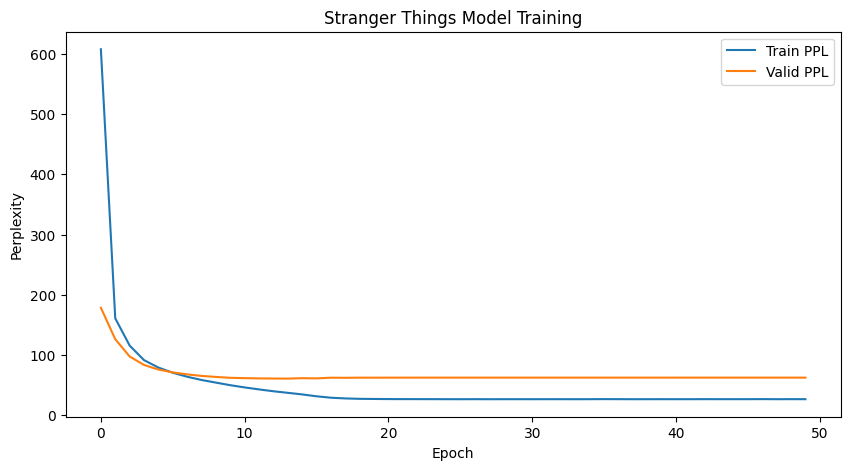

In [9]:
def get_batch(data, seq_len, idx):
    real_seq_len = min(seq_len, data.shape[1] - 1 - idx)
    src = data[:, idx:idx+real_seq_len]
    target = data[:, idx+1:idx+1+real_seq_len]
    return src, target

n_epochs = 50
seq_len = SEQ_LEN
clip = 0.25
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

train_losses = []
valid_losses = []
best_valid_loss = float('inf')

for epoch in range(n_epochs):
    model.train()
    hidden = model.init_hidden(BATCH_SIZE, device)
    epoch_loss = 0
    num_batches = train_data.shape[-1]

    for idx in tqdm(range(0, num_batches - 1, seq_len), desc=f'Epoch {epoch+1}', leave=False):
         optimizer.zero_grad()
         hidden = model.detach_hidden(hidden)
         src, target = get_batch(train_data, seq_len, idx)
         src, target = src.to(device), target.to(device)

         prediction, hidden = model(src, hidden)
         loss = criterion(prediction.reshape(-1, vocab_size), target.reshape(-1))
         loss.backward()
         nn.utils.clip_grad_norm_(model.parameters(), clip)
         optimizer.step()
         epoch_loss += loss.item() * seq_len

    train_loss = epoch_loss / num_batches

    model.eval()
    hidden = model.init_hidden(BATCH_SIZE, device)
    epoch_loss = 0
    num_batches = valid_data.shape[-1]
    with torch.no_grad():
        for idx in range(0, num_batches - 1, seq_len):
            hidden = model.detach_hidden(hidden)
            src, target = get_batch(valid_data, seq_len, idx)
            src, target = src.to(device), target.to(device)
            prediction, hidden = model(src, hidden)
            loss = criterion(prediction.reshape(-1, vocab_size), target.reshape(-1))
            epoch_loss += loss.item() * seq_len
    valid_loss = epoch_loss / num_batches

    scheduler.step(valid_loss)
    train_ppl = math.exp(train_loss)
    valid_ppl = math.exp(valid_loss)
    train_losses.append(train_ppl)
    valid_losses.append(valid_ppl)

    print(f'Epoch: {epoch+1} | Train PPL: {train_ppl:.3f} | Valid PPL: {valid_ppl:.3f}')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        save_artifact(model.state_dict(), 'stranger_things_model.pt')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train PPL')
plt.plot(valid_losses, label='Valid PPL')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Stranger Things Model Training')
plt.legend()
plt.show()

## Task 3. Text Generation

In [10]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, device):
    model.eval()
    tokens = tokenizer(prompt)
    indices = [vocab.stoi.get(t, vocab.unk_index) for t in tokens]
    batch_size = 1
    hidden = model.init_hidden(batch_size, device)

    with torch.no_grad():
        for i in range(max_seq_len):
            src = torch.LongTensor([indices]).to(device)
            prediction, hidden = model(src, hidden)
            probs = torch.softmax(prediction[:, -1] / temperature, dim=-1)
            prediction = torch.multinomial(probs, num_samples=1).item()
            indices.append(prediction)

    return [vocab.itos[i] for i in indices if vocab.itos[i] not in ['<unk>', '<eos>', '<pad>']]

# Load Best Model
def load_best_model():
    app_dir = os.path.join(PROJECT_PATH, 'app')
    if not os.path.exists(app_dir):
        if os.path.exists('app'): app_dir = 'app'
    path = os.path.join(app_dir, 'stranger_things_model.pt')
    if os.path.exists(path):
        return path
    return 'stranger_things_model.pt'

load_path = load_best_model()
print(f"Loading model from: {load_path}")

model.load_state_dict(torch.load(load_path, map_location=device))

prompt = "Eleven"
print(f"Prompt: {prompt}")
print("Generated:", ' '.join(generate(prompt, 30, 0.7, model, basic_english_tokenizer, vocab, device)))

Loading model from: /content/drive/MyDrive/NLP/project_A2/app/stranger_things_model.pt
Prompt: Eleven
Generated: eleven . this is crazy . its like an six . it was . she was just like that . like that was the . and it was
